# 텍스트 요약기
### 1) 추출적 요약 : 원문에서 중요한 핵심문장, 단어를 뽑아 이들로 구성된 요약
- 단점 : 이미 존재하는 문장,단어로만 구성하여 모델의 언어표현능력 제한

###  2) 추상적 요약 : 원문에 없던 문장이라도 핵심 문맥을 반영한 새로운 문장 생성하여 요약
- 단점 : seq2seq같은 지도학습 모델사용(원문과 요약문 레이블 데이터가 둘다 필요)

### 평가지표
- ROGUE Metric
- 요약능력을 나타내는 평가지표

In [75]:
import json
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import torch
import joblib
import pickle

### 데이터 불러오기

In [2]:
# json파일 읽기

text_dir = 'C:\\Users\\Yong\\Desktop\\text\\'
with open(text_dir + 'Training\\신문기사_train_original\\train_original.json', 'r', encoding = 'utf-8') as f:
    json_data_train =json.load(f)
    
with open(text_dir + 'Validation\\신문기사_valid_original\\valid_original.json', 'r', encoding = 'utf-8') as f:
    json_data_val =json.load(f)
#json_string = json.dumps(json_data['documents'][0]['text'][0][2], indent=3)
#print(json_data['documents'][0]['text'][0][2])

In [3]:
# train, val set
print((len(json_data_train['documents']), len(json_data_val['documents'])))

(271093, 30122)


In [4]:
# text, abstract 리스트에 추가(train)
train_text_list=[]
train_abstract_list=[]

train_data = json_data_train['documents']
for y in range(len(train_data)):
    sentence =''
    for x in range(len(train_data[y]['text'])):
        for z in range(len(train_data[y]['text'][x])):
            sentence += (train_data[y]['text'][x][z]['sentence'] + ' ')
    train_text_list.append(sentence)
    train_abstract_list.append(train_data[y]['abstractive'][0])

In [5]:
len(train_text_list), len(train_abstract_list)

(271093, 271093)

In [6]:
# text, abstract 리스트에 추가(validation)
val_text_list=[]
val_abstract_list=[]

val_data = json_data_val['documents']
for y in range(len(val_data)):
    sentence =''
    for x in range(len(val_data[y]['text'])):
        for z in range(len(val_data[y]['text'][x])):
            sentence += (val_data[y]['text'][x][z]['sentence'] + ' ')
    val_text_list.append(sentence)
    val_abstract_list.append(val_data[y]['abstractive'][0])

In [7]:
len(val_text_list), len(val_abstract_list)

(30122, 30122)

In [8]:
train_df = pd.DataFrame([x for x in zip(train_text_list, train_abstract_list)]
                       , columns= ['text','abstract'])
train_df.head()

,text,abstract
0,ha당 조사료 400만원…작물별 차등 지원 이성훈 sinawi@hanmail.net...,전라남도가 쌀 과잉문제를 근본적으로 해결하기 위해 올해부터 벼를 심었던 논에 벼 대...
1,"8억 투입, 고소천사벽화·자산마을에 색채 입혀 이성훈 sinawi@hanmail.n...",여수시는 컬러빌리지 사업에 8억원을 투입하여 ‘색채와 빛’ 도시를 완성하여 고소천사...
2,전남드래곤즈 해맞이 다짐…선수 영입 활발 이성훈 sinawi@hanmail.net ...,전남드래곤즈 임직원과 선수단이 4일 구봉산 정상에 올라 일출을 보며 2018년 구단...
3,"11~24일, 매실·감·참다래 등 지역특화작목 이성훈 sinawi@hanmail.n...","광양시는 농업인들의 경쟁력을 높이고, 소득안정을 위해 매실·감·참다래 등 지역특화작..."
4,"홍콩 크루즈선사‘아쿠아리우스’ 4, 6월 여수항 입항 이성훈 sinawi@hanma...",올해 4월과 6월 두 차례에 걸쳐 타이완의 크루즈 관광객 4000여명이 여수에 입항...


In [9]:
validation_df = pd.DataFrame([x for x in zip(val_text_list, val_abstract_list)]
                       , columns= ['text','abstract'])
validation_df.head()

,text,abstract
0,"[ 박재원 기자 ] '대한민국 5G 홍보대사'를 자처한 문재인 대통령은 ""넓고, 체...",8일 서울에서 열린 5G플러스 전략발표에 참석한 문재인 대통령은 5G는 대한민국 혁...
1,] 당 지도부 퇴진을 놓고 바른미래당 내홍이 격화되고 있다. 바른미래당이 8일 연 ...,8일 바른미래당 최고의원 회의에 하태경 의원 등 5명의 최고의원이 지도부 퇴진을 요...
2,[ 홍윤정 기자 ] 8일 서울 올림픽공원 K아트홀. 지난 3일 한국이 세계 최초로 ...,지난 3일 한국이 세계 첫 5세대 이동통신 서비스를 보편화한 것을 축하하는 '코리안...
3,] 박원순 서울시장(사진)이 8일 고층 재개발·재건축 관련 요구에 작심한 듯 쓴소리...,박원순 서울시장은 8일 서울시청에서 열린 '골목길 재생 시민 정책 대화'에 참석하여...
4,"[ 임근호 기자 ] ""SK(주)와 미국 알파벳(구글 지주회사)의 간결한 지배구조를 ...",주주가치 포커스를 운용하는 KB자산운용이 SK와 알파벳(구글 지주회사)의 모범적 ...


In [10]:
# train, validation dataframe

train_df.shape, validation_df.shape

((271093, 2), (30122, 2))

### 불용어 사전불러오기
- https://www.ranks.nl/stopwords/korean 참고

In [11]:
stopwords = open(text_dir+'stopwords.txt', mode='rt', encoding='utf-8')
stop_words = stopwords.read().split('\n')
stop_words        # 불용어 리스트

['아',
 '휴',
 '아이구',
 '아이쿠',
 '아이고',
 '어',
 '나',
 '우리',
 '저희',
 '따라',
 '의해',
 '을',
 '를',
 '에',
 '의',
 '가',
 '으로',
 '로',
 '에게',
 '뿐이다',
 '의거하여',
 '근거하여',
 '입각하여',
 '기준으로',
 '예하면',
 '예를 들면',
 '예를 들자면',
 '저',
 '소인',
 '소생',
 '저희',
 '지말고',
 '하지마',
 '하지마라',
 '다른',
 '물론',
 '또한',
 '그리고',
 '비길수 없다',
 '해서는 안된다',
 '뿐만 아니라',
 '만이 아니다',
 '만은 아니다',
 '막론하고',
 '관계없이',
 '그치지 않다',
 '그러나',
 '그런데',
 '하지만',
 '든간에',
 '논하지 않다',
 '따지지 않다',
 '설사',
 '비록',
 '더라도',
 '아니면',
 '만 못하다',
 '하는 편이 낫다',
 '불문하고',
 '향하여',
 '향해서',
 '향하다',
 '쪽으로',
 '틈타',
 '이용하여',
 '타다',
 '오르다',
 '제외하고',
 '이 외에',
 '이 밖에',
 '하여야',
 '비로소',
 '한다면 몰라도',
 '외에도',
 '이곳',
 '여기',
 '부터',
 '기점으로',
 '따라서',
 '할 생각이다',
 '하려고하다',
 '이리하여',
 '그리하여',
 '그렇게 함으로써',
 '하지만',
 '일때',
 '할때',
 '앞에서',
 '중에서',
 '보는데서',
 '으로써',
 '로써',
 '까지',
 '해야한다',
 '일것이다',
 '반드시',
 '할줄알다',
 '할수있다',
 '할수있어',
 '임에 틀림없다',
 '한다면',
 '등',
 '등등',
 '제',
 '겨우',
 '단지',
 '다만',
 '할뿐',
 '딩동',
 '댕그',
 '대해서',
 '대하여',
 '대하면',
 '훨씬',
 '얼마나',
 '얼마만큼',
 '얼마큼',
 '남짓',
 '여',
 '얼마간',
 '약간',
 '다소',
 '좀',
 '조

In [12]:
len(stop_words)

675

### 데이터 정제

In [13]:
# 중복확인
train_df['text'].nunique() # 271093 ->

270637

In [14]:
train_df['abstract'].nunique()

271076

In [15]:
validation_df['text'].nunique() # 30122 ->

29830

In [16]:
validation_df['abstract'].nunique()

30122

In [17]:
# 중복제거(text기준)

train_df.drop_duplicates(subset=['text'], inplace=True)
validation_df.drop_duplicates(subset=['text'], inplace=True)

train_df.shape, validation_df.shape

((270637, 2), (29830, 2))

In [18]:
# null값 확인(없음)

train_df.isnull().sum().sum(), validation_df.isnull().sum().sum()

(0, 0)

### 데이터 전처리

In [19]:
# tokenizer 및 메타문자 제거하기
# 전처리 함수(각 문장)
def preprocess_sentence(sentence, remove_stopwords =True):
    #sentence = re.sub(r'\([^)]*\)', '',sentence) # 괄호로 닫힌 문자열 제거
    sentence = re.sub('([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)', '', sentence) # email주소 제거
    sentence = re.sub('(http|ftp|https)://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', sentence) # url 제거
    sentence = re.sub('([ㄱ-ㅎㅏ-ㅣ]+)', '', sentence)  # 한글자음, 모음 제거 (ㅋㅋㅎㅎ..)
    sentence = re.sub('<[^>]*>', '', sentence)          # html태그 제거(<H1> .. </H1>)
    #sentence = re.sub('[^\w\s]', '', sentence)  # 특수기호 제거
    sentence = re.sub('[-=+#/\?:^$@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\…》]', '', sentence)
    
    
    # 불용어 제거
    if remove_stopwords:    # text
        tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word)>1)
    else:                   # abstract
        tokens = ' '.join(word for word in sentence.split() if len(word)>1)
    return tokens

In [20]:
#readData = "안녕하'세'요, [는 용욱이야.!!!."
#text = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', readData)
#text

In [21]:
# text, abstract 열 전처리
clean_text_train = []
clean_summary_train =[]
clean_text_val = []
clean_summary_val = []
for x in train_df['text']:
    clean_text_train.append(preprocess_sentence(x))
for x in train_df['abstract']:
    clean_summary_train.append(preprocess_sentence(x, 0))
for x in validation_df['text']:
    clean_text_val.append(preprocess_sentence(x))
for x in validation_df['abstract']:
    clean_summary_val.append(preprocess_sentence(x, 0))

In [22]:
train_df['text'] = clean_text_train
train_df['abstract'] = clean_summary_train
validation_df['text'] = clean_text_val
validation_df['abstract'] = clean_summary_val

In [23]:
train_df.isnull().sum().sum(), validation_df.isnull().sum().sum()

(0, 0)

텍스트의 최소 길이 : 42
텍스트의 최대 길이 : 2957
텍스트의 평균 길이 : 203.77634248088768
요약의 최소 길이 : 0
요약의 최대 길이 : 155
요약의 평균 길이 : 27.353111363191285


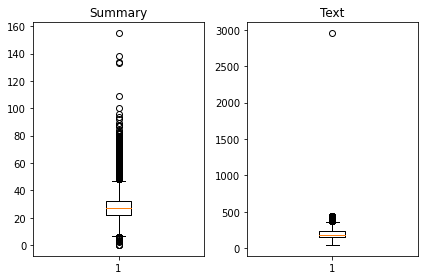

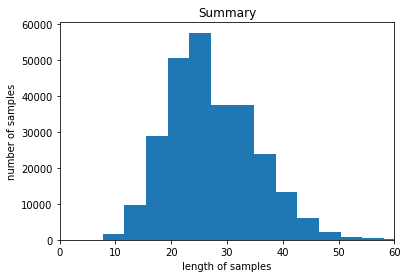

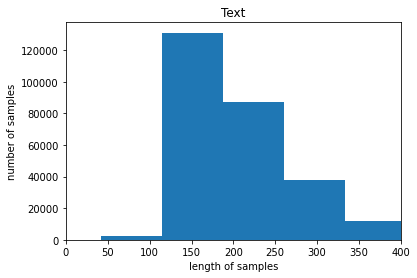

In [24]:
# text열과 abstract열에 대해 길이 분포 확인(train)
# 길이 분포 출력
text_len = [len(s.split()) for s in train_df['text']]
summary_len = [len(s.split()) for s in train_df['abstract']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.xlim([0,60])
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.xlim([0,400])
plt.show()

In [25]:
train_df

,text,abstract
0,ha당 조사료 400만원작물별 차등 지원 이성훈 전라남도가 과잉문제를 근본적으로 해...,전라남도가 과잉문제를 근본적으로 해결하기 위해 올해부터 벼를 심었던 논에 대신 사료...
1,"8억 투입, 고소천사벽화·자산마을에 색채 입혀 이성훈 여수시는 원도심 일대에서 추진...",여수시는 컬러빌리지 사업에 8억원을 투입하여 색채와 빛’ 도시를 완성하여 고소천사벽...
2,전남드래곤즈 해맞이 다짐선수 영입 활발 이성훈 전남드래곤즈사장 신승재는 지난 4일 ...,전남드래곤즈 임직원과 선수단이 4일 구봉산 정상에 올라 일출을 보며 2018년 구단...
3,"1124일, 매실·감·참다래 지역특화작목 이성훈 광양시는 오는 11일부터 24일까지...","광양시는 농업인들의 경쟁력을 높이고, 소득안정을 위해 매실·감·참다래 지역특화작목 ..."
4,"홍콩 크루즈선사아쿠아리우스’ 4, 6월 여수항 입항 이성훈 타이완의 크루즈관광객 4...",올해 4월과 6월 차례에 걸쳐 타이완의 크루즈 관광객 4000여명이 여수에 입항해 ...
...,...,...
271088,"노유정 기자 조양호 한진그룹 회장의 갑작스런 타계 소식이 전해진 8일 오전, 서울 ...",8일 미국에서 들려온 조양호 한진그룹 회장의 사망 소식에 서울 공항동 대한항공 본사...
271089,조양호 한진그룹 회장이 타계하자 재계는 일제히 추모성명을 냈다. 전국경제인연합회는 ...,조양호 한진그룹 회장이 타계하고 8일 전국경제인연합회는 논평을 통해 한국 항공과 물...
271090,김익환 기자 조양호 한진그룹 회장이 타계하면서 그의 재산을 물려받을 장남 조원태 대...,"회장의 한진칼, 한진 상장회사의 주식가격 총합은 3560억 정도 되며 이에 할증률이..."
271091,김보형 기자 조양호 한진그룹 회장이 8일 타계하면서 그의 장남인 조원태 대한항공 사...,"지난 8일 조양호 한진그룹 회장이 별세하면서 한진그룹은 비상경영체제에 돌입했고, 그..."


In [26]:
validation_df

,text,abstract
0,"박재원 기자 '대한민국 5G 홍보대사'를 자처한 문재인 대통령은 넓고, 체증 없는 ...",8일 서울에서 열린 5G플러스 전략발표에 참석한 문재인 대통령은 5G는 대한민국 혁...
1,지도부 퇴진을 놓고 바른미래당 내홍이 격화되고 있다. 바른미래당이 8일 최고위원 회...,8일 바른미래당 최고의원 회의에 하태경 의원 5명의 최고의원이 지도부 퇴진을 요구하...
2,홍윤정 기자 8일 서울 올림픽공원 K아트홀. 지난 3일 한국이 세계 최초로 5세대5...,지난 3일 한국이 세계 5세대 이동통신 서비스를 보편화한 것을 축하하는 '코리안 5...
3,박원순 서울시장사진이 8일 고층 재개발·재건축 관련 요구에 작심한 쓴소리를 쏟아냈다...,박원순 서울시장은 8일 서울시청에서 열린 '골목길 재생 시민 정책 대화'에 참석하여...
4,임근호 기자 SK주와 미국 알파벳구글 지주회사의 간결한 지배구조를 배워라. 기업 지...,주주가치 포커스를 운용하는 KB자산운용이 SK와 알파벳구글 지주회사의 모범적 지배구...
...,...,...
30117,영주시는 이억만리에서 건너온 계절근로자들의 향수를 달래고 안정된 한국생활 적응을 돕...,"영주시는 외국인 근로자들의 향수를 달래고, 안정적인 한국생활 적응을 지원하기 위해 ..."
30118,여름 방학을 맞아 전국의 국립과학관에서 탐사 50주년과 국제천문연맹IAU 설립 10...,탐사 50주년과 국제천문연맹IAU설립 100주년 기념하는 특별전시가 전국의 국립과학...
30119,영주문경예천 당원협의회 시국강연 당원교육에 참석차 영주를 방문한 황교안오른쪽 자유한...,황교안 대표는 지난 29일 자유한국당 대표로 경북 영주문경예청 당원협의회 당원교육에...
30120,경북예천군은 장기적인 국내 경기침체가 지속됨에 사회적경제 기업 육성 등을 통한 일자...,경북예천군은 사회적경제 기업 육성 등을 통한 일자리 창출에 행정동력을 집중한 결과 ...


# 1. 추출적 요약(TextRank)
- KoNLPy 를 tokenizer로 사용

In [27]:
pip install git+https://github.com/lovit/textrank.git

  Cloning https://github.com/lovit/textrank.git to c:\users\yong\appdata\local\temp\pip-req-build-d38nspoo
  Resolved https://github.com/lovit/textrank.git to commit 578c7fbbb22b24561b1bd4bab9a9ecc2dc9515e1
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none -q https://github.com/lovit/textrank.git 'C:\Users\Yong\AppData\Local\Temp\pip-req-build-d38nspoo'


In [28]:
#pip install JPype1-1.1.2-cp37-cp37m-win_amd64.whl 

In [29]:
pip install konlpy

Note: you may need to restart the kernel to use updated packages.


In [30]:
#pip install textrank

In [31]:
# 문장 요약
from konlpy.tag import Komoran
from textrank import KeysentenceSummarizer
import textrank

komoran = Komoran()
def komoran_tokenizer(sent):
    words = komoran.pos(sent, join=True)
    words = [w for w in words if ('/NN' in w or '/XR' in w or '/VA' in w or '/VV' in w)]
    return words

summarizer = KeysentenceSummarizer(
    tokenize = komoran_tokenizer,
    min_sim = 0.3,
    verbose = False
)
sents = [
    '오패산터널 총격전 용의자 검거 서울 연합뉴스 경찰 관계자들이 19일 오후 서울 강북구 오패산 터널 인근에서 사제 총기를 발사해 경찰을 살해한 용의자 성모씨를 검거하고 있다 성씨는 검거 당시 서바이벌 게임에서 쓰는 방탄조끼에 헬멧까지 착용한 상태였다',
    '서울 연합뉴스 김은경 기자 사제 총기로 경찰을 살해한 범인 성모 46 씨는 주도면밀했다',
    '경찰에 따르면 성씨는 19일 오후 강북경찰서 인근 부동산 업소 밖에서 부동산업자 이모 67 씨가 나오기를 기다렸다 이씨와는 평소에도 말다툼을 자주 한 것으로 알려졌다',
    '이씨가 나와 걷기 시작하자 성씨는 따라가면서 미리 준비해온 사제 총기를 이씨에게 발사했다 총알이 빗나가면서 이씨는 도망갔다 그 빗나간 총알은 지나가던 행인 71 씨의 배를 스쳤다',
    '성씨는 강북서 인근 치킨집까지 이씨 뒤를 쫓으며 실랑이하다 쓰러뜨린 후 총기와 함께 가져온 망치로 이씨 머리를 때렸다',
    '이 과정에서 오후 6시 20분께 강북구 번동 길 위에서 사람들이 싸우고 있다 총소리가 났다 는 등의 신고가 여러건 들어왔다',
    '5분 후에 성씨의 전자발찌가 훼손됐다는 신고가 보호관찰소 시스템을 통해 들어왔다 성범죄자로 전자발찌를 차고 있던 성씨는 부엌칼로 직접 자신의 발찌를 끊었다',
    '용의자 소지 사제총기 2정 서울 연합뉴스 임헌정 기자 서울 시내에서 폭행 용의자가 현장 조사를 벌이던 경찰관에게 사제총기를 발사해 경찰관이 숨졌다 19일 오후 6시28분 강북구 번동에서 둔기로 맞았다 는 폭행 피해 신고가 접수돼 현장에서 조사하던 강북경찰서 번동파출소 소속 김모 54 경위가 폭행 용의자 성모 45 씨가 쏜 사제총기에 맞고 쓰러진 뒤 병원에 옮겨졌으나 숨졌다 사진은 용의자가 소지한 사제총기',
    '신고를 받고 번동파출소에서 김창호 54 경위 등 경찰들이 오후 6시 29분께 현장으로 출동했다 성씨는 그사이 부동산 앞에 놓아뒀던 가방을 챙겨 오패산 쪽으로 도망간 후였다',
    '김 경위는 오패산 터널 입구 오른쪽의 급경사에서 성씨에게 접근하다가 오후 6시 33분께 풀숲에 숨은 성씨가 허공에 난사한 10여발의 총알 중 일부를 왼쪽 어깨 뒷부분에 맞고 쓰러졌다',
    '김 경위는 구급차가 도착했을 때 이미 의식이 없었고 심폐소생술을 하며 병원으로 옮겨졌으나 총알이 폐를 훼손해 오후 7시 40분께 사망했다',
    '김 경위는 외근용 조끼를 입고 있었으나 총알을 막기에는 역부족이었다',
    '머리에 부상을 입은 이씨도 함께 병원으로 이송됐으나 생명에는 지장이 없는 것으로 알려졌다',
    '성씨는 오패산 터널 밑쪽 숲에서 오후 6시 45분께 잡혔다',
    '총격현장 수색하는 경찰들 서울 연합뉴스 이효석 기자 19일 오후 서울 강북구 오패산 터널 인근에서 경찰들이 폭행 용의자가 사제총기를 발사해 경찰관이 사망한 사건을 조사 하고 있다',
    '총 때문에 쫓던 경관들과 민간인들이 몸을 숨겼는데 인근 신발가게 직원 이모씨가 다가가 성씨를 덮쳤고 이어 현장에 있던 다른 상인들과 경찰이 가세해 체포했다',
    '성씨는 경찰에 붙잡힌 직후 나 자살하려고 한 거다 맞아 죽어도 괜찮다 고 말한 것으로 전해졌다',
    '성씨 자신도 경찰이 발사한 공포탄 1발 실탄 3발 중 실탄 1발을 배에 맞았으나 방탄조끼를 입은 상태여서 부상하지는 않았다',
    '경찰은 인근을 수색해 성씨가 만든 사제총 16정과 칼 7개를 압수했다 실제 폭발할지는 알 수 없는 요구르트병에 무언가를 채워두고 심지를 꽂은 사제 폭탄도 발견됐다',
    '일부는 숲에서 발견됐고 일부는 성씨가 소지한 가방 안에 있었다'
]

keysents = summarizer.summarize(sents, topk=3)

In [32]:
for sent_idx, rank, sent in keysents:
    print(sent)

오패산터널 총격전 용의자 검거 서울 연합뉴스 경찰 관계자들이 19일 오후 서울 강북구 오패산 터널 인근에서 사제 총기를 발사해 경찰을 살해한 용의자 성모씨를 검거하고 있다 성씨는 검거 당시 서바이벌 게임에서 쓰는 방탄조끼에 헬멧까지 착용한 상태였다
용의자 소지 사제총기 2정 서울 연합뉴스 임헌정 기자 서울 시내에서 폭행 용의자가 현장 조사를 벌이던 경찰관에게 사제총기를 발사해 경찰관이 숨졌다 19일 오후 6시28분 강북구 번동에서 둔기로 맞았다 는 폭행 피해 신고가 접수돼 현장에서 조사하던 강북경찰서 번동파출소 소속 김모 54 경위가 폭행 용의자 성모 45 씨가 쏜 사제총기에 맞고 쓰러진 뒤 병원에 옮겨졌으나 숨졌다 사진은 용의자가 소지한 사제총기
신고를 받고 번동파출소에서 김창호 54 경위 등 경찰들이 오후 6시 29분께 현장으로 출동했다 성씨는 그사이 부동산 앞에 놓아뒀던 가방을 챙겨 오패산 쪽으로 도망간 후였다


In [33]:
keysents

[(0,
  1.7010195551998453,
  '오패산터널 총격전 용의자 검거 서울 연합뉴스 경찰 관계자들이 19일 오후 서울 강북구 오패산 터널 인근에서 사제 총기를 발사해 경찰을 살해한 용의자 성모씨를 검거하고 있다 성씨는 검거 당시 서바이벌 게임에서 쓰는 방탄조끼에 헬멧까지 착용한 상태였다'),
 (7,
  1.4886043194936454,
  '용의자 소지 사제총기 2정 서울 연합뉴스 임헌정 기자 서울 시내에서 폭행 용의자가 현장 조사를 벌이던 경찰관에게 사제총기를 발사해 경찰관이 숨졌다 19일 오후 6시28분 강북구 번동에서 둔기로 맞았다 는 폭행 피해 신고가 접수돼 현장에서 조사하던 강북경찰서 번동파출소 소속 김모 54 경위가 폭행 용의자 성모 45 씨가 쏜 사제총기에 맞고 쓰러진 뒤 병원에 옮겨졌으나 숨졌다 사진은 용의자가 소지한 사제총기'),
 (8,
  1.4278590385659577,
  '신고를 받고 번동파출소에서 김창호 54 경위 등 경찰들이 오후 6시 29분께 현장으로 출동했다 성씨는 그사이 부동산 앞에 놓아뒀던 가방을 챙겨 오패산 쪽으로 도망간 후였다')]

In [34]:
# 중요 키워드 추출
from textrank import KeywordSummarizer

summarizer = KeywordSummarizer(tokenize=komoran_tokenizer, min_count=2, min_cooccurrence=1)
summarizer.summarize(sents, topk=20)

[('용의자/NNP', 3.040833543583403),
 ('사제총/NNP', 2.505798518168069),
 ('성씨/NNP', 2.4254730689696298),
 ('서울/NNP', 2.399522533743009),
 ('경찰/NNG', 2.2541631612221043),
 ('오후/NNG', 2.154778397410354),
 ('폭행/NNG', 1.9019818685234693),
 ('씨/NNB', 1.7517679455874249),
 ('발사/NNG', 1.658959293729613),
 ('맞/VV', 1.618499063577056),
 ('분/NNB', 1.6164369966921637),
 ('번동/NNP', 1.4681655196749035),
 ('현장/NNG', 1.4530182347939307),
 ('시/NNB', 1.408892735491178),
 ('경찰관/NNP', 1.4012941012332316),
 ('조사/NNG', 1.4012941012332316),
 ('일/NNB', 1.3922748983755766),
 ('강북구/NNP', 1.332317291003927),
 ('연합뉴스/NNP', 1.3259099432277819),
 ('이씨/NNP', 1.2869280494707418)]

In [35]:
sents = train_df['text'][0]
n_sents = sents.replace('다','다.').split('.')
summarizer = KeysentenceSummarizer(
    tokenize = komoran_tokenizer,
    min_sim = 0.3,
    verbose = False
)
keysents1 = summarizer.summarize(n_sents, topk=3)
for sent_idx, rank, sent in keysents1:
    print(sent)

ha당 조사료 400만원작물별 차등 지원 이성훈 전라남도가 과잉문제를 근본적으로 해결하기 위해 올해부터 시행하는 생산조정제를 적극 추진키로 했다
 지원사업 대상은 2017년산 변동직불금을 받은 농지에 10a300평 이외 작물을 재배한 농업인이다
”며“쌀 공급과잉을 구조적으로 해결하도록 타작물 재배 지원사업에 많이 참여해주길 바란다


# 2. 추상적 요약
### 시퀀스-투-시퀀스 모델(seq2seq)
- 입력된 시퀀스로부터 다른 도메인의 시퀀스를 출력하는 모델
- ex).. 챗봇(입,출력을 질문과 대답), 기계번역(입출력을 문장과 번역문장), 요약, STT등
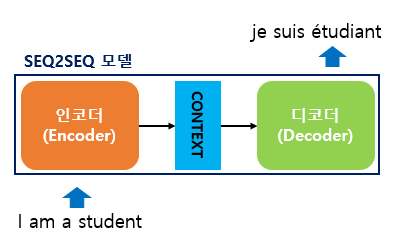
- context벡터는 보통 수백차원 이상
- 두개의 RNN아키텍쳐(인코더,디코더) 실제로는 성능문제로 LSTM, GRU셀들로 구성
- 단어의 토큰화를 통해 단어단위로 인코더에서 쪼개지고 인코더 RNN셀은 마지막 시점의 은닉상태를 디코더 RNN셀로 넘겨줌(컨텍스트 벡터) -> 디코더RNN셀의 첫번째 은닉상태로 사용

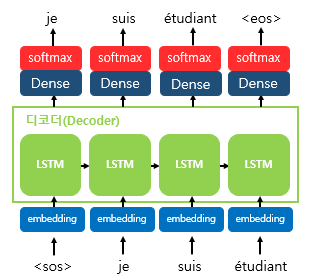

### 형태소분석을 위해 모델(한국어 언어모델)
 https://littlefoxdiary.tistory.com/81

- KoBART-summarization 사용
    - https://github.com/SKT-AI/KoBART
    - 논문에서 사용된 Text Infilling 노이즈 함수를 사용하여 40GB 이상의 한국어 텍스트에 대해서 학습한 한국어 encoder-decoder 언어 모델(한국어 위키 백과 이외, 뉴스, 책, 모두의 말뭉치 v1.0(대화, 뉴스, ...), 청와대 국민청원 등)
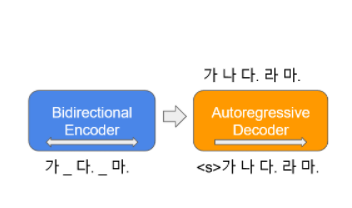

In [36]:
!git clone https://github.com/seujung/KoBART-summarization.git

fatal: destination path 'KoBART-summarization' already exists and is not an empty directory.


In [37]:
pip install kobart-transformers

Note: you may need to restart the kernel to use updated packages.


In [38]:
cd KoBART-summarization

C:\Users\Yong\코드스테이츠 AI\Section Project\Project1\KoBART-summarization


In [39]:
pip install git+https://github.com/SKT-AI/KoBART#egg=kobart

  Cloning https://github.com/SKT-AI/KoBART to c:\users\yong\appdata\local\temp\pip-install-9jqy43h_\kobart_43a001c4502049d09f983c375ef71e00
  Resolved https://github.com/SKT-AI/KoBART to commit 51e7319ab0e305df377110e08f06f6bf5fc60d48
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached pytorch_lightning-1.2.1-py3-none-any.whl (814 kB)
  Using cached torch-1.7.1-cp37-cp37m-win_amd64.whl (184.1 MB)
  Using cached transformers-4.3.3-py3-none-any.whl (1.9 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0
    Uninstalling torch-1.10.0:
      Successfully uninstalled torch-1.10.0
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none -q https://github.com/SKT-AI/KoBART 'C:\Users\Yong\AppData\Local\Temp\pip-install-9jqy43h_\kobart_43a001c4502049d09f983c375ef71e00'
ERROR: Could not install packages due to an OSError: [WinError 5] 액세스가 거부되었습니다: 'c:\\users\\yong\\anaconda3\\lib\\site-packages\\~7rch\\lib\\asmjit.dll'
Consider using the `--user` option or check the permissions.



In [40]:
pip install -r requirements.txt

  Using cached transformers-4.3.3-py3-none-any.whl (1.9 MB)
  Using cached pytorch_lightning-1.2.1-py3-none-any.whl (814 kB)


  Attempting uninstall: transformers
    Found existing installation: transformers 4.8.2
    Uninstalling transformers-4.8.2:
      Successfully uninstalled transformers-4.8.2
  Attempting uninstall: streamlit
    Found existing installation: streamlit 1.1.0
    Uninstalling streamlit-1.1.0:
      Successfully uninstalled streamlit-1.1.0
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 1.3.8
    Uninstalling pytorch-lightning-1.3.8:
      Successfully uninstalled pytorch-lightning-1.3.8
Note: you may need to restart the kernel to use updated packages.


In [41]:
cd data

C:\Users\Yong\코드스테이츠 AI\Section Project\Project1\KoBART-summarization\data


In [42]:
!tar -zxvf train.tar.gz

x train.tsv


In [43]:
!tar -zxvf test.tar.gz

x test.tsv


In [44]:
# 전처리된 데이터 추가 후 학습시켜보기

df_train_tsv = pd.read_csv("train.tsv", delimiter='\t')
df_test_tsv = pd.read_csv("test.tsv", delimiter='\t')
df_train_tsv.head()

,news,summary
0,일제 강제징용피해자들이 지난 2월 발의된 ‘근로정신대 피해자 지원법률안’의 조속한 ...,13일 광주시의회 시민 소통실에서 시민단체 '근로정신대 할머니와 함께 하는 시민모임...
1,문재인 대통령이 이르면 9일 중폭 개각을 단행할 것으로 보인다. 여권 관계자는 8일...,"문재인 대통령이 이르면 9일 장관 3~4명, 장관급 3명을 교체하는 개각을 단행하고..."
2,전남 어촌마을 정주여건 개선 ‘탄력’ 해수부 공모서 고흥 득량도·강진 신전 등 4개...,"해양수산부 어촌종합개발 거점 개발사업에 전남 고흥 득량도, 강진 신전, 완도 충동,..."
3,여자친구 알몸을 무단으로 촬영해 인터넷 성인 카페에 유포한 남성이 재판에 넘겨졌다....,피해자 A씨는 가해자인 B씨의 엄벌을 촉구하며 국민청원에 피해사실을 공개하였고 결국...
4,대구시의회 배지숙 의장이 개회를 선언하고 있다. 대구시의회(의장 배지숙)는 14일부...,대구시의회가 14일 제1차 본회의를 시작으로 제265회 임시회를 개최하고 ‘대구시시...


In [45]:
df_test_tsv.head()

,news,summary
0,계약금 10%·중도금무이자융자·6개월 후 전매가능 기자 아파트 분양시장이 실수요자 ...,태왕의 '성당 태왕아너스 메트로'모델하우스는 초역세권 입지와 변화하는 라이프스타일에...
1,▲ 박동우 안양동안경찰서 경비교통과 경장 이른 새벽 옆방에서 장난감 소리가 들려온다...,최근 늘어나고 있는 집회시위에서 소음이 문제가 되고 있는데 현행 집회와 시위에 관한...
2,"지난 19일 옛 망주초등학교에서 송귀근 고흥군수와 송우섭 군의회 의장, 귀농·귀촌인...",지난 19일 고흥군에 따르면 송귀근 군수와 주민 등 300여 명이 참석한 가운데 귀...
3,여자 하이다이빙 금메달을 차지한 호주 이프랜드(오른쪽) 선수가 환호하고 있다. /김...,23일 조선대학교에서 열린 여자 하이다이빙 최종전에서 호주의 이프랜드가 금메달을 차...
4,"시간선택제 공무원 채용 공고, 사이버국가고시센터 11개 부처에서 34명 선발, 5월...","사이버 국가고시센터에서는 시간선택제 공무원을 선발 하는데, 시간선택제 공무원은 통상..."


In [46]:
train_df['news'] = train_df['text']
train_df['summary'] = train_df['abstract']
train_df.drop(['text','abstract'],axis=1, inplace=True)
validation_df['news'] = validation_df['text']
validation_df['summary'] = validation_df['abstract']
validation_df.drop(['text','abstract'],axis=1, inplace=True)

train_final = pd.concat([df_train_tsv, train_df])
test_final = pd.concat([df_test_tsv, validation_df])

In [47]:
# dataframe to tsv

train_final.to_csv('train.tsv', index=False, header=True, sep='\t')
test_final.to_csv('test.tsv', index=False, header=True, sep='\t')

In [48]:
train_final

,news,summary
0,일제 강제징용피해자들이 지난 2월 발의된 ‘근로정신대 피해자 지원법률안’의 조속한 ...,13일 광주시의회 시민 소통실에서 시민단체 '근로정신대 할머니와 함께 하는 시민모임...
1,문재인 대통령이 이르면 9일 중폭 개각을 단행할 것으로 보인다. 여권 관계자는 8일...,"문재인 대통령이 이르면 9일 장관 3~4명, 장관급 3명을 교체하는 개각을 단행하고..."
2,전남 어촌마을 정주여건 개선 ‘탄력’ 해수부 공모서 고흥 득량도·강진 신전 등 4개...,"해양수산부 어촌종합개발 거점 개발사업에 전남 고흥 득량도, 강진 신전, 완도 충동,..."
3,여자친구 알몸을 무단으로 촬영해 인터넷 성인 카페에 유포한 남성이 재판에 넘겨졌다....,피해자 A씨는 가해자인 B씨의 엄벌을 촉구하며 국민청원에 피해사실을 공개하였고 결국...
4,대구시의회 배지숙 의장이 개회를 선언하고 있다. 대구시의회(의장 배지숙)는 14일부...,대구시의회가 14일 제1차 본회의를 시작으로 제265회 임시회를 개최하고 ‘대구시시...
...,...,...
271088,"노유정 기자 조양호 한진그룹 회장의 갑작스런 타계 소식이 전해진 8일 오전, 서울 ...",8일 미국에서 들려온 조양호 한진그룹 회장의 사망 소식에 서울 공항동 대한항공 본사...
271089,조양호 한진그룹 회장이 타계하자 재계는 일제히 추모성명을 냈다. 전국경제인연합회는 ...,조양호 한진그룹 회장이 타계하고 8일 전국경제인연합회는 논평을 통해 한국 항공과 물...
271090,김익환 기자 조양호 한진그룹 회장이 타계하면서 그의 재산을 물려받을 장남 조원태 대...,"회장의 한진칼, 한진 상장회사의 주식가격 총합은 3560억 정도 되며 이에 할증률이..."
271091,김보형 기자 조양호 한진그룹 회장이 8일 타계하면서 그의 장남인 조원태 대한항공 사...,"지난 8일 조양호 한진그룹 회장이 별세하면서 한진그룹은 비상경영체제에 돌입했고, 그..."


In [49]:
cd ../

C:\Users\Yong\코드스테이츠 AI\Section Project\Project1\KoBART-summarization


In [50]:
# gpu환경
#!python train.py  --gradient_clip_val 1.0 --max_epochs 10 --default_root_dir logs  --gpus 1 --batch_size 4 --num_workers 2

In [51]:
# cpu환경
#!python train.py  --gradient_clip_val 1.0 --max_epochs 1 --default_root_dir logs  --batch_size 4 --num_workers 4

from kobart import get_kobart_tokenizer

kobart_tokenizer = get_kobart_tokenizer()
kobart_tokenizer.tokenize("안녕하세요. 이용욱 입니다!")

from transformers import BartModel
from kobart import get_pytorch_kobart_model, get_kobart_tokenizer

kobart_tokenizer = get_kobart_tokenizer()
model = BartModel.from_pretrained(get_pytorch_kobart_model())
inputs = kobart_tokenizer(['안녕하세요.'], return_tensors='pt')
model(inputs['input_ids'])

In [65]:
# https://github.com/hyunwoongko/kobart-transformers 참고
from transformers import PreTrainedTokenizerFast, BartForConditionalGeneration

# 모델과 문장분리를 위한 토크나이저
tokenizer = PreTrainedTokenizerFast.from_pretrained("gogamza/kobart-summarization")
model = BartForConditionalGeneration.from_pretrained("gogamza/kobart-summarization")

#### 위 셀과 같음
from kobart_transformers import get_kobart_tokenizer
from kobart_transformers import get_kobart_for_conditional_generation

kobart_tokenizer = get_kobart_tokenizer()
kobart_model = get_kobart_for_conditional_generation()

In [108]:
news_text = "세계가 ‘오미크론(Omicron)’ 공포에 빠졌다. 코로나19 델타변이도 잡지 못해 전전긍긍하는데 세계보건기구(WHO)가 또 다른 ‘우려 변이(variant of concern)’로 오미크론을 지정하면서다. 항체를 무력화 수 있는 돌연변이가 많은 걸로 파악되는 오미크론이 코로나19 백신엔 어떤 영향을 미칠지를 보려면 추가 연구가 필요한 상황이다. 각 국은 서둘러 국경의 빗장을 걸고 있다. 미국과 유럽 등 글로벌 증시를 폭락시킨 오미크론은 현재로선 어디로 튈지 모르는 변이여서 두려움을 더하고 있다."
#news_text = preprocess_sentence(news_text)
# 토크나이저를 사용하여 뉴스기사 원문을 모델이 인식할 수 있는 토큰형태로 바꿔줍니다.
input_ids = tokenizer.encode(news_text)
print(input_ids)

[28589, 14143, 11841, 10746, 13090, 10341, 23601, 308, 16968, 313, 14889, 28102, 19023, 11786, 14621, 24002, 14469, 10338, 9495, 15874, 25863, 13123, 10869, 25933, 23905, 17551, 14038, 12126, 9246, 9246, 16144, 14370, 20126, 17842, 19995, 271, 278, 15092, 14153, 14355, 14143, 11911, 10313, 14296, 12034, 239, 317, 15562, 304, 15195, 315, 19524, 16637, 14889, 298, 14879, 309, 240, 18407, 14075, 10746, 13090, 16298, 16241, 14457, 14130, 14577, 16428, 23582, 13714, 14032, 14082, 14327, 11806, 10869, 15028, 14467, 26185, 15920, 14343, 14075, 10746, 13090, 20983, 14469, 10338, 9495, 15874, 14566, 11467, 11788, 14593, 15587, 20667, 14404, 14046, 16939, 14927, 14541, 8981, 15490, 14431, 16247, 14319, 14071, 12005, 23987, 14071, 21521, 19238, 14324, 23153, 15964, 19593, 15251, 14048, 15365, 14258, 16632, 14556, 10214, 16366, 14075, 10746, 13090, 22686, 14475, 10338, 11268, 26531, 1700, 13312, 12332, 17989, 14296, 12034, 19266, 18018, 15065, 14166, 14058, 15964]


In [109]:
# 모델에 넣기 전 문장의 시작과 끝을 나타내는 토큰을 추가합니다.
input_ids = [tokenizer.bos_token_id] + input_ids + [tokenizer.eos_token_id]
input_ids = torch.tensor([input_ids])

In [110]:
input_ids

tensor([[    0, 28589, 14143, 11841, 10746, 13090, 10341, 23601,   308, 16968,
           313, 14889, 28102, 19023, 11786, 14621, 24002, 14469, 10338,  9495,
         15874, 25863, 13123, 10869, 25933, 23905, 17551, 14038, 12126,  9246,
          9246, 16144, 14370, 20126, 17842, 19995,   271,   278, 15092, 14153,
         14355, 14143, 11911, 10313, 14296, 12034,   239,   317, 15562,   304,
         15195,   315, 19524, 16637, 14889,   298, 14879,   309,   240, 18407,
         14075, 10746, 13090, 16298, 16241, 14457, 14130, 14577, 16428, 23582,
         13714, 14032, 14082, 14327, 11806, 10869, 15028, 14467, 26185, 15920,
         14343, 14075, 10746, 13090, 20983, 14469, 10338,  9495, 15874, 14566,
         11467, 11788, 14593, 15587, 20667, 14404, 14046, 16939, 14927, 14541,
          8981, 15490, 14431, 16247, 14319, 14071, 12005, 23987, 14071, 21521,
         19238, 14324, 23153, 15964, 19593, 15251, 14048, 15365, 14258, 16632,
         14556, 10214, 16366, 14075, 10746, 13090, 2

In [111]:
summary_text_ids = model.generate(
    input_ids=input_ids,
    bos_token_id=model.config.bos_token_id,
    eos_token_id=model.config.eos_token_id,
    length_penalty=2.0, # 길이에 대한 penalty값. 1보다 작은 경우 더 짧은 문장을 생성하도록 유도하며, 1보다 클 경우 길이가 더 긴 문장을 유도
    max_length=128,     # 요약문의 최대 길이 설정
    min_length=32,      # 요약문의 최소 길이 설정
    num_beams=4,        # 문장 생성시 다음 단어를 탐색하는 영역의 개수 
)
print(tokenizer.decode(summary_text_ids.squeeze(), skip_special_tokens=True))

세계보건기구(WHO)가 항체를 무력화 할 수 있는 돌연변이가 많은 걸로 파악되는 오미크론이 코로나19 백신엔 어떤 영향을 미칠지를 보려면 추가 연구가 필요한 상황으로 세계보건기구(WHO)가 세계보건기구(WHO)가 또 다른 ‘우려 변이’로 오미크론을 지정하면서 글로벌 증시를 폭락시킨 오미크론은 현재로선 어디로 튈지 모르는 변이여서 두려움을 더하고 있다.


In [112]:
summary_text_ids = model.generate(
    input_ids=input_ids,
    bos_token_id=model.config.bos_token_id,
    eos_token_id=model.config.eos_token_id,
    length_penalty=1.0, # 길이에 대한 penalty값. 1보다 작은 경우 더 짧은 문장을 생성하도록 유도하며, 1보다 클 경우 길이가 더 긴 문장을 유도
    max_length=128,     # 요약문의 최대 길이 설정
    min_length=32,      # 요약문의 최소 길이 설정
    num_beams=4,        # 문장 생성시 다음 단어를 탐색하는 영역의 개수 
)

print(tokenizer.decode(summary_text_ids.squeeze(), skip_special_tokens=True))

# penalty 값을 줄여 더 나은 요약확인

세계보건기구(WHO)가 항체를 무력화 할 수 있는 돌연변이가 많은 걸로 파악되는 오미크론이 코로나19 백신엔 어떤 영향을 미칠지를 보려면 추가 연구가 필요한 상황이다.


In [71]:
input_id1 = tokenizer.encode(train_df['news'][0])
input_id1 = [tokenizer.bos_token_id] + input_id1 + [tokenizer.eos_token_id]
input_id1 = torch.tensor([input_id1])

summary_text_id1 = model.generate(
    input_ids=input_id1,
    bos_token_id=model.config.bos_token_id,
    eos_token_id=model.config.eos_token_id,
    length_penalty=2.0, # 길이에 대한 penalty값. 1보다 작은 경우 더 짧은 문장을 생성하도록 유도하며, 1보다 클 경우 길이가 더 긴 문장을 유도
    max_length=128,     # 요약문의 최대 길이 설정
    min_length=32,      # 요약문의 최소 길이 설정
    num_beams=4,        # 문장 생성시 다음 단어를 탐색하는 영역의 개수 
)
print(tokenizer.decode(summary_text_id1.squeeze(), skip_special_tokens=True))

전라남도는 논에 벼를 심었던 논에 대신 사료작물이나 작물을 심으면 벼와의 일정 소득차를 보전해주는 생산조정제를 적극 추진키로 했다.


In [72]:
print(tokenizer.decode(summary_text_id1[0], skip_special_tokens=True))

전라남도는 논에 벼를 심었던 논에 대신 사료작물이나 작물을 심으면 벼와의 일정 소득차를 보전해주는 생산조정제를 적극 추진키로 했다.


# 평가지표(ROGUE)
- 시스템요약(모델이 생성한 요약), 참조요약(사람이 만들어놓은 요약)
- Rogue에서의 precision과 recall
    - Recall : 참조 요약본을 구성하는 단어중 몇개의 단어가 시스템 요약본의 단어와 겹치는지(시스템요약본이 엄청 긴 문장일때 참조요약본과 크게 관련이 없어도 단어가 많이 겹칠 수 있음)
    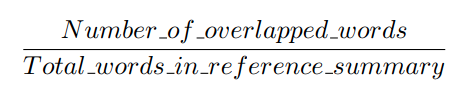
    
    - Precision : recall의 문제를 해결하기 위해 계산, 시스템요약본 중 참조요약본과 겹치는 단어

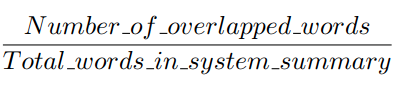
- 정확한 성능평가를 위해 precision과 recall 계산후 F-score 측정
- 간결한 요약을 생성하고 있다면 precison은 성능평가에 큰 고려사항이 아님(recall만 사용)

- (N-gram : 임의의 개수를 정하기 위한 기준, n개의 연속적인 단어 나열)
####  ROUGE-1 : 시스템 요약본과 참조 요약본 간 겹치는 unigram의 수(n=1)
#### ROUGE-2 : 시스템 요약본과 참조 요약본 간 겹치는 bigram의 수(n=2) ex) the cat, the bed.. 

### 기타 ROUGE지표 참고
- https://huffon.github.io/2019/12/07/rouge/

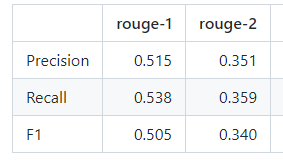

### 모델저장(pkl)


In [81]:
joblib.dump(model, 'C:/Users/Yong/코드스테이츠 AI/Section Project/Project1/flask_app/model/model.pkl')
# # Saving model to disk
# pickle.dump(regressor, open('model.pkl','wb'))

['C:/Users/Yong/코드스테이츠 AI/Section Project/Project1/flask_app/model/model.pkl']

In [117]:
'C:\\Users\\Yong\\코드스테이츠 AI\\Section Project\\Project1\\flask_app'

'C:\\Users\\Yong\\코드스테이츠 AI\\Section Project\\Project1\\KoBART-summarization'

In [ ]:
text_dir = 'C:\\Users\\Yong\\Desktop\\text\\'
stopwords = open(text_dir+'stopwords.txt', mode='rt', encoding='utf-8')
stop_words = stopwords.read().split('\n')

def preprocess_sentence(sentence, remove_stopwords =True):
    #sentence = re.sub(r'\([^)]*\)', '',sentence) # 괄호로 닫힌 문자열 제거
    sentence = re.sub('([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)', '', sentence) # email주소 제거
    sentence = re.sub('(http|ftp|https)://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', sentence) # url 제거
    sentence = re.sub('([ㄱ-ㅎㅏ-ㅣ]+)', '', sentence)  # 한글자음, 모음 제거 (ㅋㅋㅎㅎ..)
    sentence = re.sub('<[^>]*>', '', sentence)          # html태그 제거(<H1> .. </H1>)
    #sentence = re.sub('[^\w\s]', '', sentence)  # 특수기호 제거
    sentence = re.sub('[-=+#/\?:^$@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\…》]', '', sentence)
    
    
    # 불용어 제거
    if remove_stopwords:    # text
        tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word)>1)
    else:                   # abstract
        tokens = ' '.join(word for word in sentence.split() if len(word)>1)
    return tokens

In [119]:
# 다시 불러와서 사용할 부분
from transformers import PreTrainedTokenizerFast

model_test = joblib.load('C:/Users/Yong/코드스테이츠 AI/Section Project/Project1/flask_app/model/model.pkl')

news_text = input()
news_text = preprocess_sentence(news_text)
input_ids = tokenizer.encode(news_text)
input_ids = [tokenizer.bos_token_id] + input_ids + [tokenizer.eos_token_id]
input_ids = torch.tensor([input_ids])


model_summary = model_test.generate(
    input_ids=input_ids,
    bos_token_id=model_test.config.bos_token_id,
    eos_token_id=model_test.config.eos_token_id,
    length_penalty=2.0, # 길이에 대한 penalty값. 1보다 작은 경우 더 짧은 문장을 생성하도록 유도하며, 1보다 클 경우 길이가 더 긴 문장을 유도
    max_length=128,     # 요약문의 최대 길이 설정
    min_length=32,      # 요약문의 최소 길이 설정
    num_beams=4,        # 문장 생성시 다음 단어를 탐색하는 영역의 개수 
)
tokenizer = PreTrainedTokenizerFast.from_pretrained("gogamza/kobart-summarization")
print('텍스트 요약 : {}'.format(tokenizer.decode(model_summary.squeeze(), skip_special_tokens=True)))

adsfafd
텍스트 요약 : adsfafafddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddd


In [118]:
tokenizer.decode(model_summary.squeeze(), skip_special_tokens=True)

'세계보건기구WHO가 항체를 무력화 있는 돌연변이가 많은 걸로 파악되는 오미크론이 코로나19 백신엔 영향을 미칠지를 보려면 추가 연구가 필요한 상황으로 세계보건기구WHO가 세계보건기구WHO가 우려 변이’로 오미크론을 지정하면서 글로벌 증시를 폭락시킨 오미크론은 현재로선 어디로 튈지 모르는 변이여서 두려움을 더하고 있다.'

### 참고자료
https://www.slideshare.net/BOAZbigdata/deeptitle?fbclid=IwAR2GHvEwLC-cvnlbjhvbKc0dxT7Xyof0CjooXvrcejqJoPN_cFLk6ewbMjQ

- Konlpy : https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=myincizor&logNo=221629109172

- 한국어 언어모델정리 : https://littlefoxdiary.tistory.com/81

- koBart : https://github.com/SKT-AI/KoBART